In [2]:
import json
import numpy as np
import logging
import h5py
from tqdm import tqdm

np.random.seed(0)
logging.basicConfig(
    filename="./logs/log_getdataset.txt",
    filemode='a',
    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
    datefmt='%H:%M:%S',
    level=logging.INFO
)
logger=logging.getLogger() 
logger.setLevel(logging.INFO) 

VERSION = "_rl_final_new2_cate_test4"
FILTER = ""
VERSION = "_reddit"
FILTER = "_filter"
with open(f"../dataset/sock_puppets{VERSION}.json", "r") as json_file:
    data = json.load(json_file)[2]["data"]

with open(f"../dataset/video_ids{VERSION}.json", "r") as json_file:
    video_ids = json.load(json_file)

with open(f"../dataset/category_ids_new.json", "r") as json_file:
    cate_ids = json.load(json_file)

with open(f"../dataset/video_metadata{VERSION}.json", "r") as json_file:
    video_metadata = json.load(json_file)


In [3]:
def sample_false_label(
    label: list, 
    num_labels: int, 
    max_label_len: int=100
):
    ret = label
    true_label = dict(zip(ret, [0 for _ in range(len(ret))]))
    false_label = list(np.random.randint(num_labels, size=max_label_len + 10 * len(label)))

    idx = 0
    while len(ret) < max_label_len:
        if false_label[idx] in true_label.keys():
            idx +=1 
            continue
        ret.append(false_label[idx])
        idx += 1
    return ret


cnt = 0
missed_videos = {}
input_data_all = []
label_data_all = []
label_type_data_all = []
mask_data_all = []
last_label_all = []
last_label_p_all = []
last_label_type_all = []
last_cate_norm_all = []

max_label_len = 1000
max_trail_len = 40
topk_home = 100
last_gain = 1
initial_home_video_ids = {}
unique_home_video_id = {}
for i in tqdm(range(len(data))):
    initial_home_video_ids.update(dict(zip(data[i]["initial_homepage"], [1 for _ in range(len(data[i]["initial_homepage"]))])))
    video_views = data[i]["homepage"]
    tmp = {}
    for video_view in video_views:
        for video_id in video_view:
            if video_id in initial_home_video_ids.keys():
                continue
            if video_id not in unique_home_video_id.keys():
                unique_home_video_id[video_id] = 0
            if video_id not in tmp.keys():
                tmp[video_id] = 1
                unique_home_video_id[video_id] += 1
            else:
                tmp[video_id] = 1
print(len(initial_home_video_ids))

removed_videos = []
for video in unique_home_video_id.keys():
    if unique_home_video_id[video] > 0 and unique_home_video_id[video] < 100:
        removed_videos.append(video)
for video in removed_videos:
    del unique_home_video_id[video]

print(len(unique_home_video_id))

# unique_home_video_id = {}
tmp = {}
for i in tqdm(range(len(data))):
    # try:
    input_data = []
    mask_data = []

    # Get video trails
    video_views = data[i]["viewed"]
    tmp[str(video_views)] = 1
    for video_id in video_views:
        # if video_id in video_ids.keys():
        input_data.append(video_ids[video_id])
        mask_data.append(1)

    # Append -1 if the length of trail is smaller than max_trail_len
    if len(input_data) > 41:
        print(len(input_data))
    if len(input_data) < max_trail_len:
        for _ in range(max_trail_len-len(input_data)):
            input_data.append(-1)
            mask_data.append(0)

    # Get recommended video trails
    rec_trails = data[i]["recommendation_trail"]
    label_data = []
    label_type_data = []
    for j in range(len(rec_trails)):
        label = []
        label_type = []
        trail = rec_trails[j]

        # # Get all the recommended videos each step
        # for video_id in trail:
        #     label.append(video_ids[video_id])
        #     label_type.append(1)
        
        # Label_type: 0 -> true label, 1 -> false label
        label_type += [0 for _ in range(max_label_len-len(label_type))]

        # Generate false labels
        label = sample_false_label(label, len(video_ids.keys()), max_label_len)
        label_data.append(np.array(label))
        label_type_data.append(np.array(label_type))

    # Get homepage recommendation
    home_recs = data[i]["homepage"]

    # In the last step, we want to predict the homepage videos
    last_label = []
    last_label_type = []
    last_cate = [0.01 for _ in range(len(cate_ids))]
    home_video_ids = {}
    for home_rec in home_recs:
        for video_id in home_rec:
            if video_id in initial_home_video_ids.keys():
                continue
            if video_id in unique_home_video_id.keys():
                continue
            if video_id not in home_video_ids.keys():
                home_video_ids[video_id] = 0
            home_video_ids[video_id] += 1

    home_video_ids = {k : v for k, v in sorted(home_video_ids.items(), key=lambda item: item[1], reverse=True)}
    last_label = [video_ids[video_id] for video_id in list(home_video_ids.keys())[0:topk_home]]
    # print(len(last_label))
    last_label_p = [value for value in list(home_video_ids.values())[0:topk_home]]
    last_label_type = [1 for _ in range(len(last_label))]

    for video_id in list(home_video_ids.keys())[0:topk_home]:
        try:
            last_cate[cate_ids[video_metadata[video_id]["categories"]]] += 1
        except:
            continue
    last_cate_norm = [last_cate[i] / sum(last_cate) for i in range(len(last_cate))]
    # print(last_cate_norm)

    # Label_type: 0 -> true label, 1 -> false label
    last_label_type += [0 for _ in range(max_label_len * last_gain - len(last_label_type))]

    # Generate false labels
    last_label = sample_false_label(last_label, len(video_ids.keys()), max_label_len * last_gain)
    last_label_p = [value / sum(last_label_p) for value in last_label_p]
    last_label_p += [0 for _ in range(max_label_len * last_gain - len(last_label_p))]
    
    # Append zero matrix if the length of label list is smaller than max_trail_len
    if len(label_data) < max_trail_len:
        for _ in range(max_trail_len-len(label_data)):
            label_data.append(np.array(label)*0)
            label_type_data.append(np.array(label_type)*0)

    input_data_all.append(np.array(input_data))
    label_data_all.append(np.array(label_data))
    label_type_data_all.append(np.array(label_type_data))
    mask_data_all.append(np.array(mask_data))
    last_label_all.append(np.array(last_label))
    last_label_p_all.append(np.array(last_label_p))
    last_label_type_all.append(np.array(last_label_type))
    last_cate_norm_all.append(np.array(last_cate_norm))

    # except:
    #     cnt += 1
    
logger.info("Missing {} trails.".format(cnt))



  0%|          | 0/9939 [00:00<?, ?it/s]

5590
3368


 41%|████      | 4056/9939 [01:14<01:49, 53.83it/s]

In [ ]:
print(cate_ids)
print(last_cate_norm_all[4])

NameError: name 'cate_ids' is not defined

No. of videos: 127085


100%|██████████| 127085/127085 [00:00<00:00, 593451.20it/s]


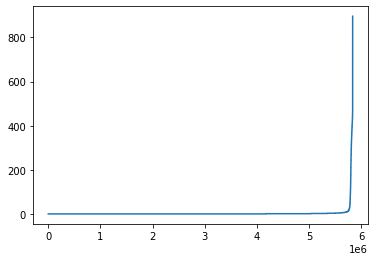

815


DatabaseError: 2003 (HY000): Can't connect to MySQL server on '127.0.0.1:3306' (111)